# nufebtools demo
Extracting colony and voronoi morphological features from a NUFEB hdf5 datafile

Complements talk given 2021-April-24 during the ORNL-NUFEB Meeting.

In [1]:
# Import the standard stuff
import os
import sys
import h5py
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Nufebtools currently contains one module, area2d in which all the functions reside. This and the naming
# are subject to change up to version 1.0.0, after that all existing function names and signatures will be
# stable within any given major point release (a.k.a, we're using semantic versioning)
from nufebtools import area2d # version 0.0.1

This analysis is performed on one run, using the the ```nufebtools``` package.  It has been set up, however, so that all relevant inputs are parameters in the next code block.  Notably, the code block has been tagged as ```parameters```, which allows the notebook to be called with ```papermill```.  

This enables a simple script (or command line one-liner) to apply the notebook across a series of runs. For example, in a directory containing a set of Runs named ```Run_1_1``` through ```Run_<N>_1```, the following would apply to the script to every run and save the resulting analysis output in the default per-run subdirectories:

```find . -type d -name 'Run_*' -exec papermill -p dry_run False -p save_plot_colony_growth True -p rundir {} <notebook.ipynb> /dev/null \;```

**Big notice:** We were orginally testing out using notebooks directly in a pipeline, hence the stuff about ```papermill```.  We have recently decided toinstead use regular scripts within the pipeline.  Functionally this just means that the ```find``` call above would be executing <python scriptname.py> and passing input parameters as appropriate.  Little should changes in terms of what those parameters are, how the script itself uses the package, and how the script is applied to multiple runs.

In [2]:
# flag to keep us from doing stuff we only want done when manually running the notebook
# implication is that papermill should definitely pass this parameter as False
interactive = True

# We may want to ocassionally generate figures non-interactively
# setting these to True will override interactive for the associated figure
save_plot_colony_growth = False
save_plot_facets = False

# In a dry run, don't actually write output
dry_run = False

# Absolute path to directory containing the run information
# nb this is usually set to empty and passed as a paremeter from papermill, but has been set here for the demo
rundir = '/home/joe/professional/research/NUFEB-cyanobacteria/data/exploratory/fourth_test_with_dist/distributions/Run_4_1'

# Within a run directory, where to find run results and write output
resultsdir = 'Results'
outdir = 'shape_metrics'

# Name of the hdf5 encoded file with all dumped NUFEB output
h5file = 'trajectory.h5'

# Internally, we are working with simple generated images, so we need a scale factor relating
# specifying pixels per meter.
# We don't specify the absolute image height and width since we'd ideally like to generate analysis images
# at the same resolution as the real lab images
px_pm = 3e6

# x and y dimensions in meters of simulation
# TODO all current runs use this span, but it there should be a supplemental script which understands the input
# files and is used to populate these parameters
sim_xspan = 1e-4
sim_yspan = 1e-4

## print diagnostic output
area2d.DEBUG_PRINT=False


**Q:** *Why we are working with images at all?*

**A:** Images are a 2D projection of the 3D biomass, which corresponds to what happens when imaging real colonies. Generating the images are actually a very simple way to calculate the appropriate projection.

**Q:** *Why are we generating images from simulation data and not using externally generated images from lammps dumps?*

**A:** Briefly, consistency and decoupling.
 
1. No need to re-run a simulation to generate necessary images. 
    1. Don't even need to generate images at all during simulation time, saving time & space. (Although they're useful for QA right now.)
1. The generated images are not necessarily the best for masking, thresholding, etc.
1. There is no gaurantee of consistency between styles applied to different runs. Generating our own keeps the analysis code simple, since it knows what to expect.
1. Makes it very easy to associate other values from the data dump (such as the seed tag) with locations within the image.

In [3]:
# height and width of simulation area in terms of image pixels
im_height = int(sim_yspan*px_pm)
im_width = int(sim_xspan*px_pm)

Just setting up the i/o and inline plotting.

In [4]:
infile = os.path.join(rundir, h5file)
os.makedirs(os.path.join(rundir, resultsdir, outdir), exist_ok=True)

if(interactive):
    %matplotlib inline
    # make inline images look a bit bigger
    plt.rcParams['figure.figsize'] = [8, 8]
    plt.rcParams['figure.dpi'] = 96

# Importing data

Right now the data is read using a direct call to ```h5py``` outside of the python package. Many of the package functions expect to passed the parsed hdf5 file and then pass it along to other functions which do things like extract all the cell locations at a given timestep. In the future, it is likely that this will be abstracted away into a ```rundata``` class.

In [5]:
# read the hdf5 file storing simulation results
traj = h5py.File(infile, 'r')

# Inferring cell ancestry

jAll cells have an ancestor, and identifying this ancestor is one way to distinguish between colonies and has proven the most suitable for this analysis.  Other methods of inferring ancestry and assigning colony identities may be usable in the future, and their differing suitabilities will be discussed.

Every cell present at the first timestep is considered a seed and is its own ancestor. All of its progeny share the same ancestor.

In [6]:
# generate a dictionary associating each cell at each timestep with an inferred ancestor
ancestry = area2d.assign_ancestry(traj)

## Under the hood

We step through the simulation and use a quick ```numpy``` filter to identify any cells present at the timestep which do not already have an ancestor.  We then do a nearest neighbor search for the closest cell with an ancestor and assume that we're related. The nearest neighbor search is unoptimized at the moment, but not time consuming at the scales we're currently running.  Optimization points are noted as ```# TODO``` within the code.

Assigning ancestry was by far the trickiest part of development and this method, while simple, turned out to have the fewest weird edge cases. It also turned out to be pretty fast vs. some of the alternatives.  In the future, NUFEB will be able to directly track cell lineages and the package will be able to take advantage of that.  Note that if we're comparing against lab images where we can't track ancestry (*i.e.,* untagged colonies)  taking advantage of that information might lead to an unbalance comparison.

# Measuring colony area

Now that we can reliably assign groups of cells to a common ancestor, we can look at colony-level morphologies, specifically the *2D visible area*, which is analagous to what would be measured in a standard top-down lab image.

The code produces a ```pandas``` dataframe which can be used directly for further data analysis (*e.g.,* fitting per-colony growth curves), or used by other functions in the package (*e.g.,* plotting, combining with facet morphology data).

In [7]:
# Get a list of timesteps and, as a convenience, start and end time listed in the run data
timesteps, start_time, end_time = area2d.get_timesteps(traj)

# Determine the area of each colony at each timestep within the simulation
colony_morpholjjogies = area2d.get_colony_morphologies_at_times(timesteps,ancestry, traj,
                                                              px_pm, im_height, im_width)
if(interactive):
    display(colony_morphologies)

,Time (s),Colony ID,Area (pixels),Scale (pixels per meter)
0,0,1,39,3000000.0
1,0,2,39,3000000.0
2,0,3,39,3000000.0
3,0,4,39,3000000.0
4,0,5,39,3000000.0
...,...,...,...,...
5605,25400,18,723,3000000.0
5606,25400,19,1326,3000000.0
5607,25400,20,1155,3000000.0
5608,25400,21,1128,3000000.0


# Under the hood
The top-level function applies to all colonies at all timesteps. It relies upon a function with processes all colonies at a single timestep. That function, in turn, relies upon the workhorse function which processes a single colony at a single timestep (thus producing one row of the above dataframe).  All of the functions have been written so that they may be called directly, if wanted.

The workhorse function simply plots, on a black background, an appropriately scaled circle (note that until updated this means it will be inaccurate for use with the bacillus atom style) for every cell at the timestep.  Cells who are part of the relevant colony are plotted in white. Others are plotted in black. Because the cells are sorted in order along the z-axis, this has the same occluding effect as one would have with a physical lab image of bugs. As written, this is performed fairly inefficiently and accounts for a large portion of the total script run time. It is one of the first things to optimize.

The area is simply a count of the number of white pixels in the image.

As written, the method currently best matches segmenting of physical images which rely upon tagging.

An alternative method would be to plot all cells as white areas and use a watershed segementation. This would be less accurate but exactly match how physical images are segmented. 

Once the alternative method is implemented, the approach used by the calling function would be selectable as a parameter (similar to how ODE solver packages allow one to select the solver approach).


# Visualizing colony growth over time

The package includes a function which returns a basic plot of colony growth, intended as either a convenience function for quick and dirty data viz or as a plot object for further refinement.

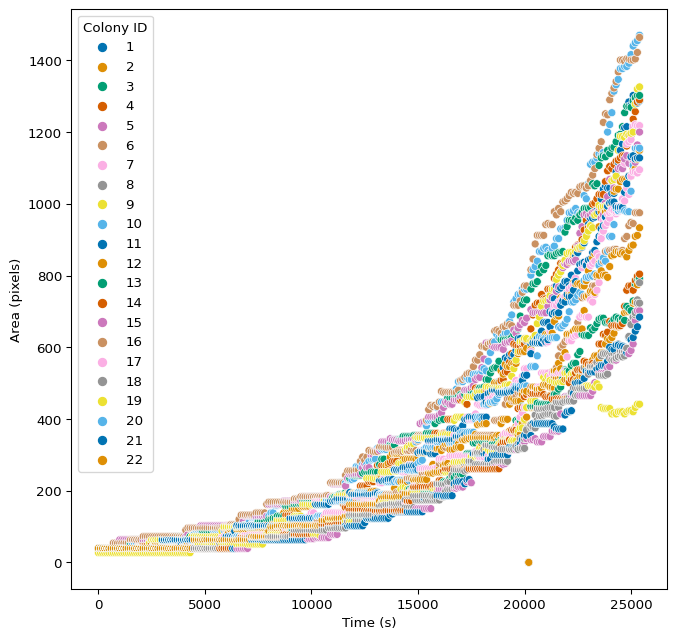

In [8]:
if(interactive | save_plot_colony_growth):
    p = area2d.plot_colony_growth(colony_morphologies)
    if(save_plot_colony_growth):
        outfile = os.path.join(rundir, resultsdir, outdir, 'colony_growth.png')
        p.get_figure().savefig(outfile)

# Voronoi tessellation

We would like to use the area of each seed's associated Voronoi facet as a feature in predicting colony growth. The following section uses a top-level function which produces a dataframe listing the area and morphological metrics of the Voronoi facets associated with each seed. It also identifies if a Voronoi facet touches the edge of the simulation area, intended as a filtering hook for situation where edge-effects should be avoided (or to determine if edge-effects are signficant)


In [9]:
facet_morphologies = area2d.get_facet_morphologies(traj,px_pm,im_height,im_width)
if(interactive):
    display(facet_morphologies)


,Seed ID,Facet Area (pixels),Facet Perimeter (pixels),Facet Aspect Ratio,Facet Sides,Is Edge Facet,Scale (pixels per meter)
0,18,2461.5,218.512184,1.928571,4,True,3000000.0
1,11,9611.0,382.686462,1.037736,5,True,3000000.0
2,8,9196.5,377.225034,1.476796,6,True,3000000.0
3,3,3872.5,276.869864,2.311111,5,True,3000000.0
4,4,3376.5,238.810211,1.106061,5,True,3000000.0
5,12,1946.0,182.845837,1.631579,4,True,3000000.0
6,5,4017.5,247.714431,1.201145,7,False,3000000.0
7,6,8029.0,360.907854,1.738233,7,False,3000000.0
8,14,4159.0,255.353589,1.174626,6,True,3000000.0
9,2,780.0,133.520767,1.733333,3,True,3000000.0


# Under the hood
Since the package can easily get the seed cell locations and OpenCV provides a Voronoi tesselation capability, the bulk of the work done by ```nufebtools``` is actually spent massaging the OpenCV facets into an appropriate form (scaling, clipping to the bounding box, identifying edge facets) and figuring out which seed id is associated with which facet.

# Drawing the tessellation

It can be useful to view the tesselation itself and ```nufebtools``` provides a method to help with that. the generated image is, under the hood, just a numpy array and returned as such, since those are easy to work with in OpenCV. To plot within a notebook, you can do the following.

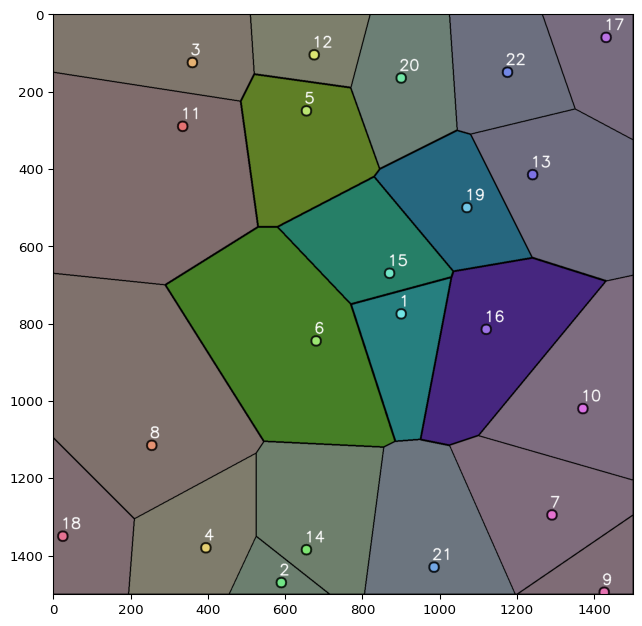

In [10]:
#Make the displayed image larger by *vizscale* while still keeping 
#the internal units correct with respect to pixels per meter.
vizscale = 5 

plt.imshow(area2d.graph_facets(traj,px_pm,im_height,im_width,vizscale))

# Producing the morphological output we probably actually care about

Based on what we're actually looking into (associating measures of colony growth with spatial variations), we probably just want to generate a big old CSV file with all the relevant information.  ```nufebtools``` contains a convenience function for doing an appropriate join on the colony and facet dataframes. It can then be written as csv using standard function calls.

Note that since this script is intended to be called on one run at a time, aggregating those CSVs into a single file would be the responsiblity of the calling environment.  In the past, I've done so using a combination of ```find```, ```cat```, ```tail -n +1``` (to remove the header line), ```paste``` to add columns for per-run associated metadata (such as the run id).

In [11]:
combined_morphologies = area2d.combine_morphologies(colonies=colony_morphologies,
                                                    facets=facet_morphologies)
if(interactive):
    display(combined_morphologies)
    
outfile = os.path.join(rundir, resultsdir, outdir, 'run_areas_2d.csv')
if(dry_run):
    print(f'Writing combined_morphologies to {outfile}')
else:
    combined_morphologies.to_csv(outfile)

,Area (pixels),Scale (pixels per meter),Facet Area (pixels),Facet Perimeter (pixels),Facet Aspect Ratio,Facet Sides,Is Edge Facet,Scale (pixels per meter) (facet),seed,winner_index,Median Colony Area (pixels),Median-Normed Colony Area,Colony ID
Time (s),,,,,,,,,,,,,
0,39,3000000.0,2545.0,227.032713,1.428966,4,False,3000000.0,1,0.015324,39.0,0.000000,1
0,39,3000000.0,780.0,133.520767,1.733333,3,True,3000000.0,2,0.050000,39.0,0.000000,2
0,39,3000000.0,3872.5,276.869864,2.311111,5,True,3000000.0,3,0.010071,39.0,0.000000,3
0,39,3000000.0,3376.5,238.810211,1.106061,5,True,3000000.0,4,0.011550,39.0,0.000000,4
0,39,3000000.0,4017.5,247.714431,1.201145,7,False,3000000.0,5,0.009708,39.0,0.000000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25400,723,3000000.0,2461.5,218.512184,1.928571,4,True,3000000.0,18,0.293723,1111.5,-0.349528,18
25400,1326,3000000.0,3277.0,234.039444,1.401639,6,False,3000000.0,19,0.404638,1111.5,0.192982,19
25400,1155,3000000.0,3375.0,229.746517,1.500623,5,True,3000000.0,20,0.342222,1111.5,0.039136,20


# Generating a plot of the colonies at a specific timestep

At times, it's a nice diagnostic tool to produce a plot of what the code thinks the colonies are at a specific timestep.  The function is very similar in usage to the facet plotting code. Adding colony id labels is a todo item.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


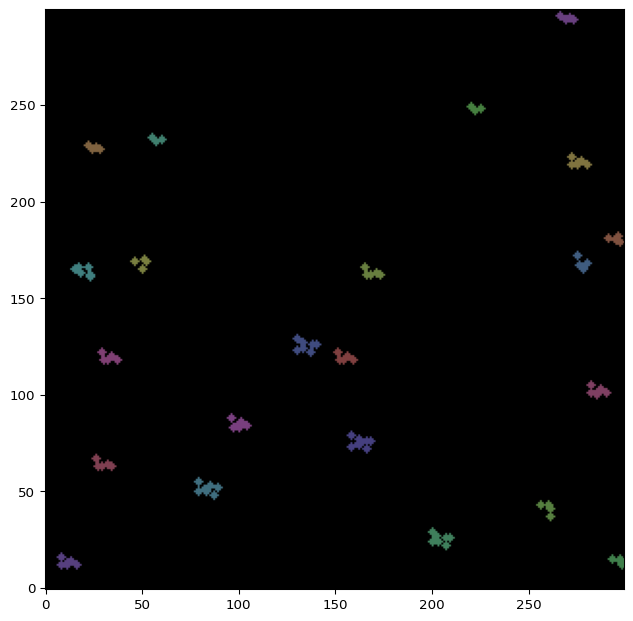

In [12]:
raw_img = area2d.plot_colonies_at_time(12000, traj, px_pm, ancestry, im_height, im_width, vizscale)

plt.imshow(raw_img)
plt.gca().invert_yaxis() # due to how coordinates are handled in numpy/OpenCV vs lammps

# N.b. the clipping input data warning is expected and not of concern.  
# N.b. the depending on the actual image height and width, indvidual cells may appear as diamonds rather than
# circles, this is a cosequence of discretization.